# CycleGAN 구현

## 1 import

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## 2 image class 정의

In [2]:
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

# horse2zebra 폴더 필요
# tranA, tranB, teatA, tesB 폴더가 그 안에 존재할 것.
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the horse2zbra"
    
    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]
        
    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))
        if item_A.shape[0] != 3:
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3:
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        # 옛버전 파이토치는 서로다른 채널의 이미지들의 normalization을 지원하지 않음.
        return (item_A - 0.5) * 2, (item_B - 0.5)* 2
    
    def __len__(self):
        return min(len(self.files_A), len(self.files_B))
        

## 3 Generator

## 3-1 FeatureMap block

In [3]:
class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

## 3-2 Contractor block
- 이전 영상의 해상도를 1/2로 줄이면서 channel의 수를 2배로 증가

In [4]:
class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_dropout=False, use_bn=True , activation='relu'):
        super(ContractingBlock, self).__init__()
        #self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        #self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
              self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

## 3-3 Residual block
이전 영상의 크기와 채널 수를 유지하면서 conv 연산을 수행. 그 결과 영상을 concatenation

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, stride=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, stride=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x) # 2번하는 이유 레이어를 만들때 중요한것. conv1를 같게 트레이닝하는 것. 필터 파라미터 2개를 독립적으로 학습시키겠다
        x = self.instancenorm(x)
        return original_x + x

## 3-4 Expander block
이전 영상의 해상도를 2배로 늘이면서 channel의 수를 1/2 배로 감소

In [6]:
class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels//2, kernel_size= 3, stride=2, padding=1, output_padding=1)
    
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels//2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

In [7]:
#ConvTranspose2d (input_channels, input_channels//2, kernel_size= 3, stride=2, padding=1, output_padding=1)


## 3-5 Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 =ContractingBlock(hidden_channels)
        self.contract2 =ContractingBlock(hidden_channels*2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()
        
    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        
        return self.tanh(xn)
        

In [9]:
import torchsummary
gen_summary = Generator(3, 3).to('cuda')
torchsummary.summary(gen_summary, (3,256,256),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             256
   FeatureMapBlock-2         [-1, 64, 256, 256]               0
            Conv2d-3        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-4        [-1, 128, 128, 128]               0
              ReLU-5        [-1, 128, 128, 128]               0
  ContractingBlock-6        [-1, 128, 128, 128]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-8          [-1, 256, 64, 64]               0
              ReLU-9          [-1, 256, 64, 64]               0
 ContractingBlock-10          [-1, 256, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-12          [-1, 256, 64, 64]               0
             ReLU-13          [-1, 256, 64, 64]               0
           Conv2d-14          [-1, 256,

## 4 discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, activation='lrelu') #  kernel_size=4
        self.contract2 = ContractingBlock(hidden_channels*2, activation='lrelu') # kernel_size=4
        self.contract3 = ContractingBlock(hidden_channels*4, activation='lrelu')#  kernel_size=4
        self.final = ContractingBlock(hidden_channels*8, 1) #, kernel_size=1

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

In [11]:
disc_summary = Discriminator(3, 3).to('cuda')
torchsummary.summary(disc_summary, (3,256,256),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 256, 256]              12
   FeatureMapBlock-2          [-1, 3, 256, 256]               0
            Conv2d-3          [-1, 6, 128, 128]             168
         LeakyReLU-4          [-1, 6, 128, 128]               0
  ContractingBlock-5          [-1, 6, 128, 128]               0
            Conv2d-6           [-1, 12, 64, 64]             660
    InstanceNorm2d-7           [-1, 12, 64, 64]               0
         LeakyReLU-8           [-1, 12, 64, 64]               0
  ContractingBlock-9           [-1, 12, 64, 64]               0
           Conv2d-10           [-1, 24, 32, 32]           2,616
   InstanceNorm2d-11           [-1, 24, 32, 32]               0
        LeakyReLU-12           [-1, 24, 32, 32]               0
 ContractingBlock-13           [-1, 24, 32, 32]               0
           Conv2d-14           [-1, 48,

## 5 초기화
## 5-1 변수 초기화

In [12]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 20
dim_A = 3
dim_B = 3
display_step = 20
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'cuda'

## 5-2 데이터 로딩

In [13]:
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("horse2zebra", transform= transform)

## 5-3 optimizer

In [14]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

#def weights_init(m):
#    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#        torch.nn.init.normal_(m.weight, 0.0, 0.02)
#    if isinstance(m, nn.InstanceNorm2d):
#        torch.nn.init.normal_(m.weight, 0.0, 0.02)
#        torch.nn.init.constant_(m.bias, 0)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen_AB = gen_AB.apply(weights_init)
gen_BA = gen_BA.apply(weights_init)
disc_A = disc_A.apply(weights_init)
disc_B = disc_B.apply(weights_init)

## 6 Loss Function

## 6-1 Discriminator loss

In [15]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    disc_fake_X_hat = disc_X(fake_X.detach())  #detach() 미분안함. Dh(Gzh(x))
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat))   # Ex~z[(D-0)^2] mseloss  저번엔 bce log   제로르 뺌
    disc_real_X_hat =   disc_X(real_X)    #Dh(y)disc_X(real_X)
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))   # Ey~H[(Dh(y)-1)^2] mseloss  저번엔 bce log   1에서 뺌  
    disc_loss = (disc_fake_X_loss+disc_real_X_loss) / 2
    
    return disc_loss

## 6-2 Generator loss

In [16]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    fake_Y = gen_XY(real_X) #미분할꺼라 티태치하면 안됨. 제네레이터이기 때문
    disc_fake_Y_hat = disc_Y(fake_Y) #D(Gzh(x))
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))
    
    return adversarial_loss, fake_Y

## 6-3 Cycle consistency loss

In [17]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    #fake_Y = gen_XY(real_X)//필요없음 있기 때문
    cycle_X = gen_YX(fake_Y)
    cycle_loss =cycle_criterion(cycle_X, real_X)
    
    return cycle_loss, cycle_X

## 6-4 Identity loss

In [18]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)
    
    return identity_loss, identity_X

In [19]:
## 7 CycleGan의 loss 함수

In [20]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    #Adversarial Loss
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB
    
    #Identity Loss
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B
    
    #Cycle-consistency Loss
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB
    
    # Total loss
    gen_loss =  gen_adversarial_loss + gen_identity_loss * lambda_identity + gen_cycle_loss * lambda_cycle
    
    return gen_loss, fake_A, fake_B

## 8 Image display 함수

In [21]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and size per image, 
    plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
    

## 9 traing

In [22]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)


def train(save_model=True):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size= batch_size, shuffle=True)
    cur_step = 0
    
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            # imgae_width = imgae.shape[3]
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)
            
            ### Update discriminator A ###
            disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True) # Update gradients
            disc_A_opt.step() # Update optimizer
            
            ### Update discriminator B ###
            
            
            
            
            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer
            
            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step
            
            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator(U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # save_model
                save_model = True
                if save_model:
                    torch.save({
                        'gen_AB' : gen_AB.state_dict(),
                        'gen_BA' : gen_BA.state_dict(),
                        'gen_opt' : gen_opt.state_dict(),
                        'disc_A' : disc_A.state_dict(),
                        'disc_A_opt' : disc_A_opt.state_dict(),
                        'disc_B' : disc_B.state_dict(),
                        'disc_B_opt' : disc_B_opt.state_dict()
                    }, f"cycleGAN_{cur_step}.pth")
            cur_step += 1
        
            
            

  0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 0: Step 0: Generator(U-Net) loss: 0.35902724266052244, Discriminator loss: 0.03126380443572998


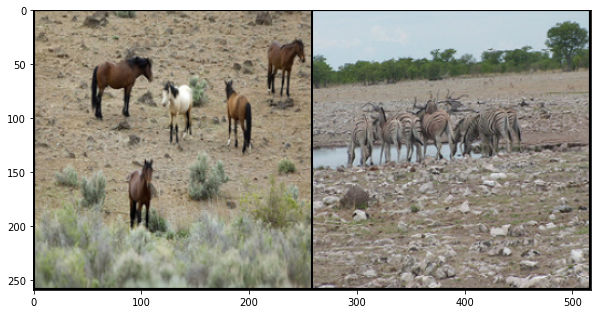

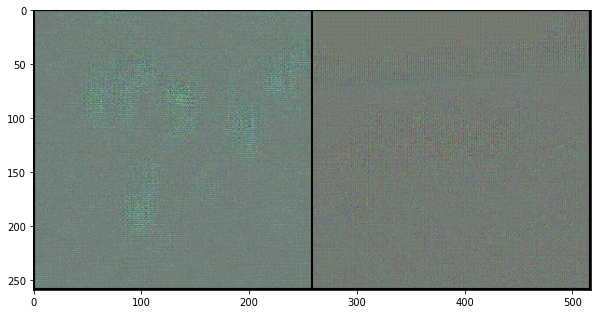

Epoch 0: Step 20: Generator(U-Net) loss: 8.574479007720946, Discriminator loss: 0.40732373744249345


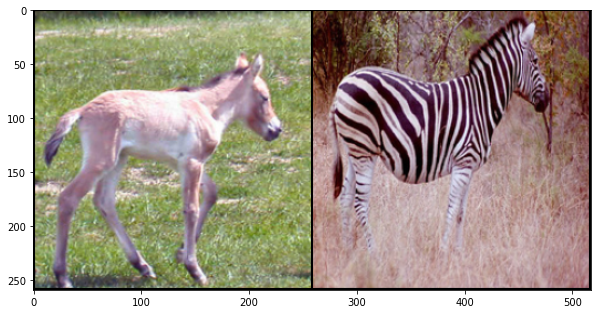

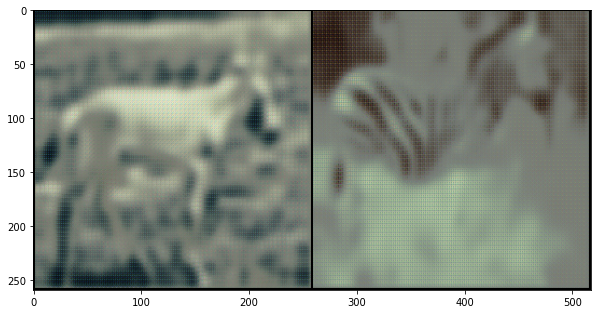

In [ ]:
train()